In [1]:
from numpy import genfromtxt

bands = genfromtxt('./helpers/bands.csv', delimiter=',')

In [2]:
leaf_pixel_x = 25
leaf_pixel_y = 25
start_band = 110
end_band = 135
band_delta = end_band - start_band
band_range = bands[start_band:end_band]

In [3]:
import numpy as np
import matplotlib.pyplot as plt

rois_old = np.empty((6, 50, 50, band_delta))
for i in range(1, 4):
    current_rois = np.load("rois_old{}.npy".format(i))
    current_rois = current_rois[..., start_band:end_band]
    rois_old = np.append(rois_old, current_rois, axis=0)

rois_old = np.delete(rois_old, np.s_[0:6], axis=0)
rois_old.shape

(18, 50, 50, 25)

In [4]:
rois_young = np.empty((6, 50, 50, band_delta))
for i in range(1, 4):
    current_rois = np.load("rois_young{}.npy".format(i))
    current_rois = current_rois[..., start_band:end_band]
    rois_young = np.append(rois_young, current_rois, axis=0)

rois_young = np.delete(rois_young, np.s_[0:6], axis=0)
rois_young.shape

(18, 50, 50, 25)

(36, 25)


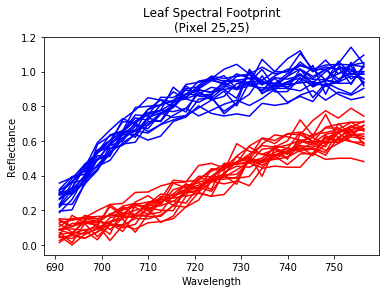

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

leaf_pixels = np.empty((1, band_delta))

for i in range(rois_old.shape[0]):
    leaf_pixel = rois_old[i, leaf_pixel_x, leaf_pixel_y, :]
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed, 'r')
    leaf_pixels = np.append(leaf_pixels, [leaf_pixel_squeezed], axis=0)
    

for i in range (rois_young.shape[0]):
    leaf_pixel = rois_young[i, leaf_pixel_x, leaf_pixel_y, :]
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed ,'b')
    leaf_pixels = np.append(leaf_pixels, [leaf_pixel_squeezed], axis=0)
    
leaf_pixels = np.delete(leaf_pixels, (0), axis=0)  
print(leaf_pixels.shape)

plt.title('Leaf Spectral Footprint\n(Pixel {},{})'.format(
    leaf_pixel_x, leaf_pixel_y))
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.show([-100, 100])

In [6]:
X = leaf_pixels
y = np.append(np.ones((18, 1), dtype=int), np.zeros((18, 1), dtype=int), axis=0)
X.shape, y.shape

((36, 25), (36, 1))

In [7]:
from sklearn.model_selection import train_test_split

# train size 5/6 or ~83.3%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36, 25), (36, 1), (30, 25), (6, 25), (30, 1), (6, 1))

In [8]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(64, input_dim=25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20)

Using TensorFlow backend.
W0203 05:57:03.944492 140618720618240 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 30 samples, validate on 6 samples
Epoch 1/20


InternalError: Blas GEMM launch failed : a.shape=(30, 25), b.shape=(25, 64), m=30, n=64, k=25
	 [[{{node dense_1/MatMul}}]]
	 [[loss/mul/_61]]

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()